# 🌍 COVID-19 Global Data Tracker

## Project Description
This project tracks global COVID-19 trends using the Our World in Data (OWID) dataset. It analyzes **cases, deaths, recoveries, and vaccinations** across countries and time. The notebook includes data cleaning, exploratory data analysis (EDA), visualizations, and narrative insights.

**Dataset Source:** [Our World in Data COVID-19 Dataset](https://github.com/owid/covid-19-data/tree/master/public/data)

**Key Features:**
- Total cases and deaths analysis
- Vaccination progress tracking
- Country comparisons (per capita and absolute)
- Time-aligned pandemic progression
- Interactive choropleth maps (if Plotly installed)

**Note:** Before running this notebook, download the `owid-covid-data.csv` file from the above link and place it in the same directory as this notebook.

In [3]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Optional for interactive maps
try:
    import plotly.express as px
    plotly_available = True
except ImportError:
    print("Plotly not installed. Install it to enable interactive maps.")
    plotly_available = False

In [4]:
# Load COVID-19 Dataset
try:
    df = pd.read_csv('../data/owid-covid-data.csv')
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
except FileNotFoundError:
    print("Dataset file not found. Make sure 'owid-covid-data.csv' is in the working directory.")
    print("Download from: https://github.com/owid/covid-19-data/tree/master/public/data")
    # Create empty dataframe to prevent errors in subsequent cells
    df = pd.DataFrame()

# Preview first 5 rows
if not df.empty:
    df.head()

Dataset loaded successfully!
Dataset shape: (429435, 67)
Date range: 2020-01-01 to 2024-08-14


## Data Exploration
- Check dataset columns, data types, and missing values.

In [5]:
# Dataset Info
if not df.empty:
    print("Dataset Information:")
    print(f"Total records: {len(df)}")
    print(f"Number of countries: {df['location'].nunique()}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")

    # Check missing values
    print("\nColumns with missing values (>30% missing):")
    missing_pct = (df.isnull().sum() / len(df)) * 100
    print(missing_pct[missing_pct > 30].sort_values(ascending=False))

    # Basic statistics for key numeric columns
    print("\nBasic statistics for key metrics:")
    key_metrics = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 
                   'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']
    available_metrics = [m for m in key_metrics if m in df.columns]
    print(df[available_metrics].describe().round(2))

Dataset Information:
Total records: 429435
Number of countries: 255
Date range: 2020-01-01 to 2024-08-14

Columns with missing values (>30% missing):
weekly_icu_admissions_per_million             97.440125
weekly_icu_admissions                         97.440125
excess_mortality_cumulative                   96.877059
excess_mortality                              96.877059
excess_mortality_cumulative_per_million       96.877059
excess_mortality_cumulative_absolute          96.877059
weekly_hosp_admissions_per_million            94.295528
weekly_hosp_admissions                        94.295528
icu_patients_per_million                      90.891287
icu_patients                                  90.891287
hosp_patients_per_million                     90.532677
hosp_patients                                 90.532677
total_boosters                                87.518484
total_boosters_per_hundred                    87.518484
new_vaccinations                              83.473401
new_tests_

## Data Cleaning
- Filter selected countries
- Convert date column to datetime
- Handle missing values
- Calculate derived metrics

In [6]:
# Data Cleaning
if not df.empty:
    # Filter countries of interest
    countries = ['United States', 'India', 'Brazil', 'United Kingdom', 'Germany', 
                 'South Africa', 'Japan', 'Australia', 'Kenya','Ethiopia']
    df_countries = df[df['location'].isin(countries)].copy()
    
    # Convert date column to datetime
    df_countries['date'] = pd.to_datetime(df_countries['date'])
    
    # Select key columns to focus on
    key_columns = ['date', 'location', 'iso_code', 'total_cases', 'new_cases', 
                  'total_deaths', 'new_deaths', 'total_vaccinations', 
                  'people_vaccinated', 'people_fully_vaccinated', 'population', 
                  'aged_65_older', 'gdp_per_capita', 'hospital_beds_per_thousand']
    
    # If any key columns are missing, create them with NaN values
    for col in key_columns:
        if col not in df_countries.columns:
            df_countries[col] = np.nan
    
    # Filter to only include our key columns
    df_countries = df_countries[key_columns]
    
    # Fill missing numeric values appropriately
    numeric_cols = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 
                   'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']
    
    for col in numeric_cols:
        if col in df_countries.columns:
            # For cumulative data, forward fill then fill remaining with 0
            if col.startswith('total_') or col.startswith('people_'):
                df_countries[col] = df_countries.groupby('location')[col].ffill().fillna(0)
            else:
                df_countries[col] = df_countries[col].fillna(0)
    
    # Calculate derived metrics
    df_countries['cases_per_million'] = (df_countries['total_cases'] / df_countries['population']) * 1e6
    df_countries['deaths_per_million'] = (df_countries['total_deaths'] / df_countries['population']) * 1e6
    
    # Calculate death rate (with handling for division by zero)
    df_countries['death_rate'] = np.where(
        df_countries['total_cases'] > 0,
        df_countries['total_deaths'] / df_countries['total_cases'],
        0
    )
    
    print(f"Data cleaned for {len(df_countries['location'].unique())} countries")
    df_countries.head()

Data cleaned for 10 countries


## Exploratory Data Analysis (EDA)
- Trends over time for total cases, deaths
- Death rate calculation: total_deaths / total_cases
- Vaccination progress

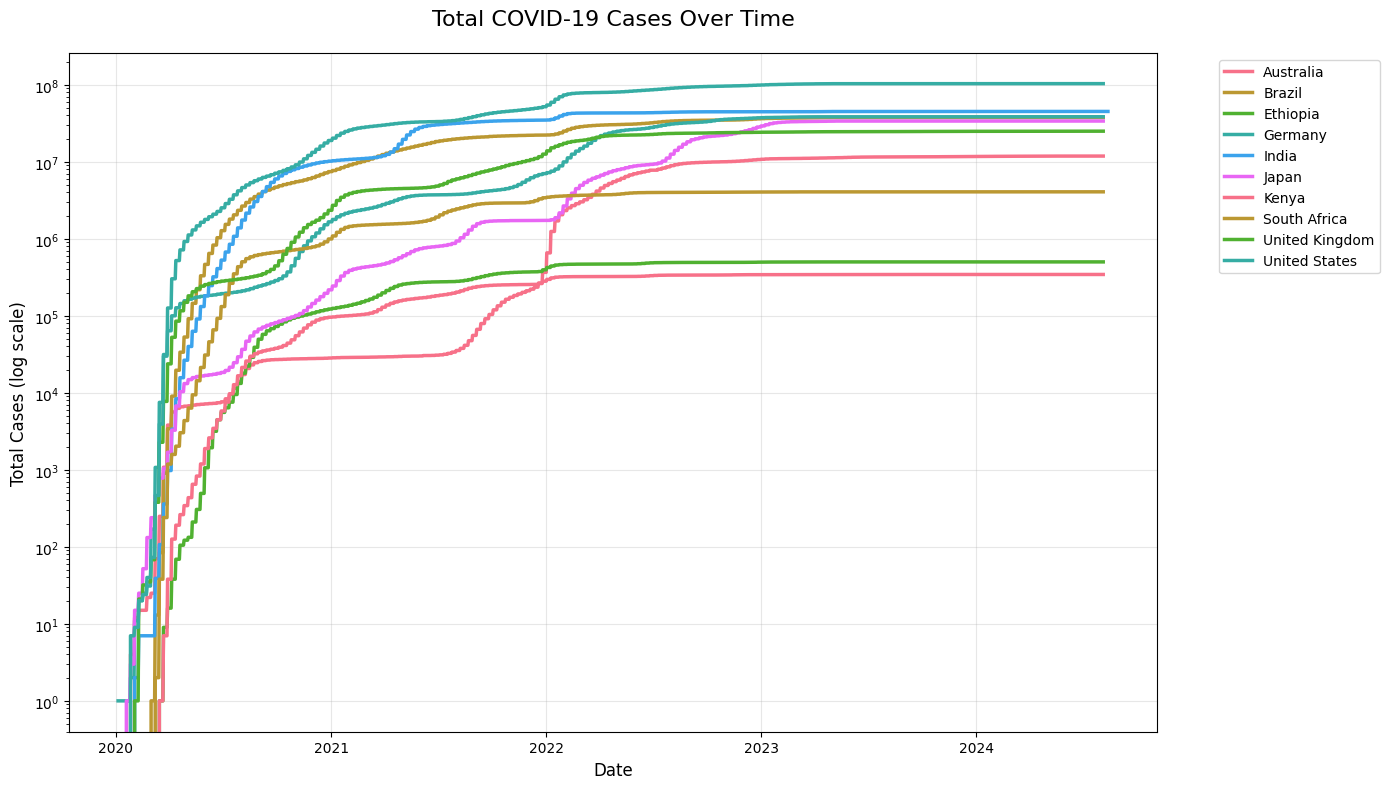

In [7]:
# Line chart: Total cases over time
if not df.empty:
    plt.figure(figsize=(14, 8))
    for country in df_countries['location'].unique():
        subset = df_countries[df_countries['location'] == country]
        plt.plot(subset['date'], subset['total_cases'], label=country, linewidth=2.5)
    
    plt.title('Total COVID-19 Cases Over Time', fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total Cases (log scale)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Use log scale due to exponential growth
    plt.tight_layout()
    plt.show()

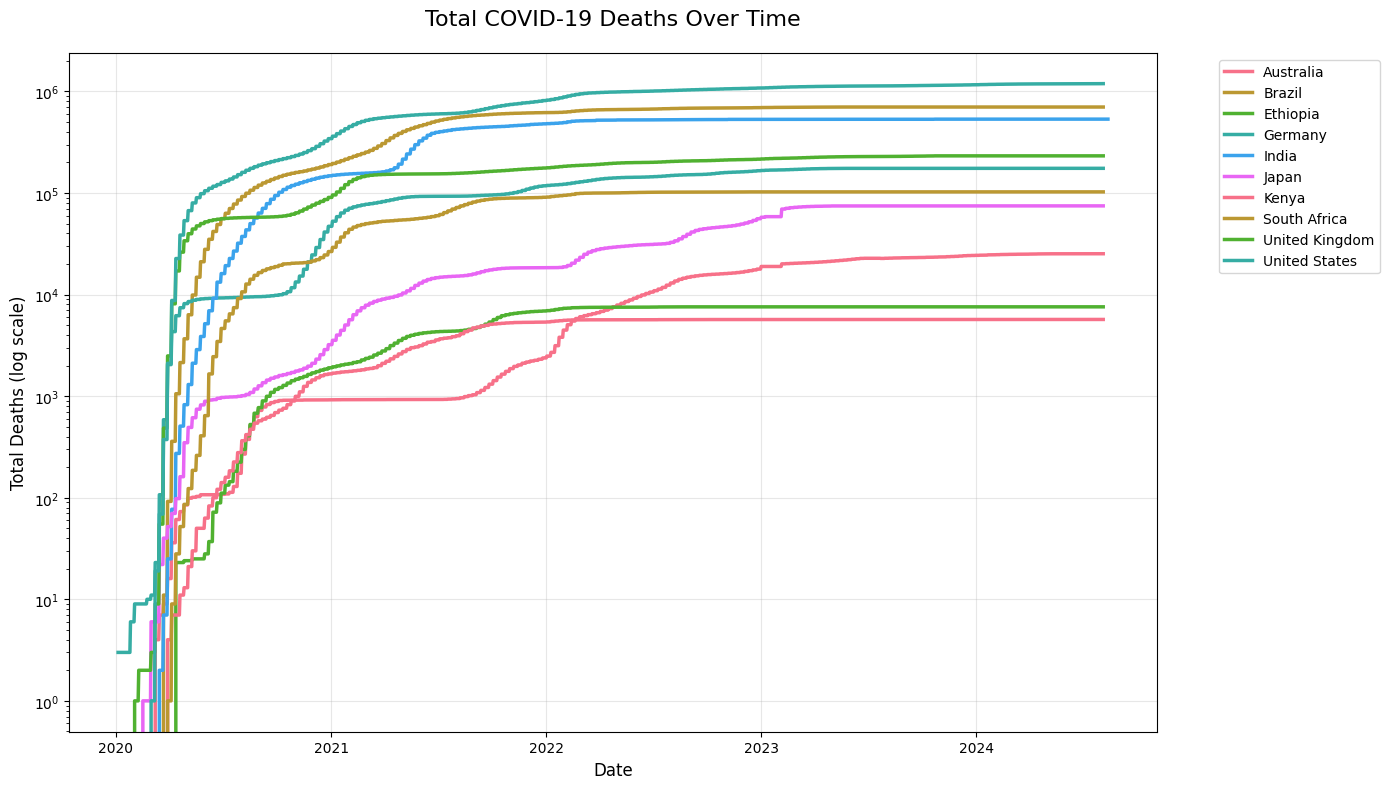

In [8]:
# Line chart: Total deaths over time
if not df.empty:
    plt.figure(figsize=(14, 8))
    for country in df_countries['location'].unique():
        subset = df_countries[df_countries['location'] == country]
        plt.plot(subset['date'], subset['total_deaths'], label=country, linewidth=2.5)
    
    plt.title('Total COVID-19 Deaths Over Time', fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total Deaths (log scale)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Use log scale due to exponential growth
    plt.tight_layout()
    plt.show()

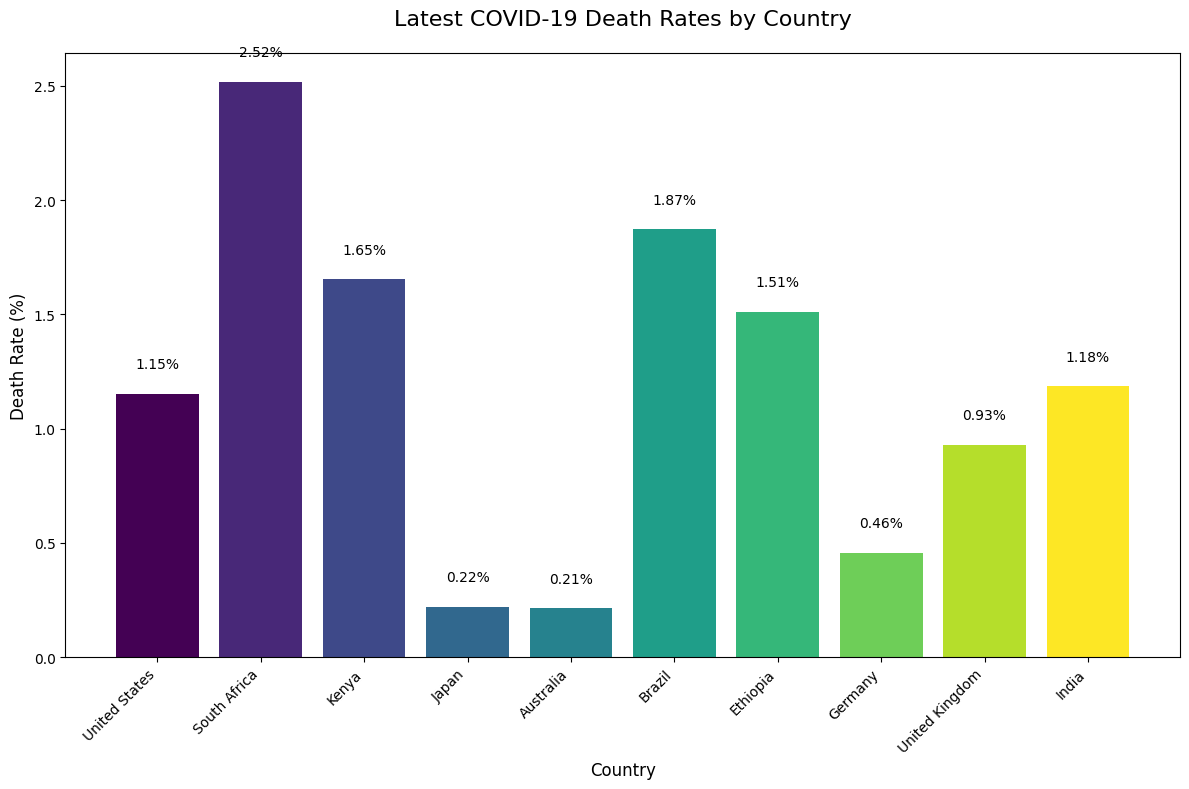

Latest Death Rates (%):
United States: 1.15%
South Africa: 2.52%
Kenya: 1.65%
Japan: 0.22%
Australia: 0.21%
Brazil: 1.87%
Ethiopia: 1.51%
Germany: 0.46%
United Kingdom: 0.93%
India: 1.18%


In [9]:
# Calculate death rate
if not df.empty:
    # Latest death rate per country
    latest = df_countries.sort_values('date').groupby('location').tail(1)
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(latest['location'], latest['death_rate'] * 100, color=plt.cm.viridis(np.linspace(0, 1, len(latest))))
    plt.title('Latest COVID-19 Death Rates by Country', fontsize=16, pad=20)
    plt.ylabel('Death Rate (%)', fontsize=12)
    plt.xlabel('Country', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print the actual values
    print("Latest Death Rates (%):")
    for _, row in latest.iterrows():
        print(f"{row['location']}: {row['death_rate']*100:.2f}%")

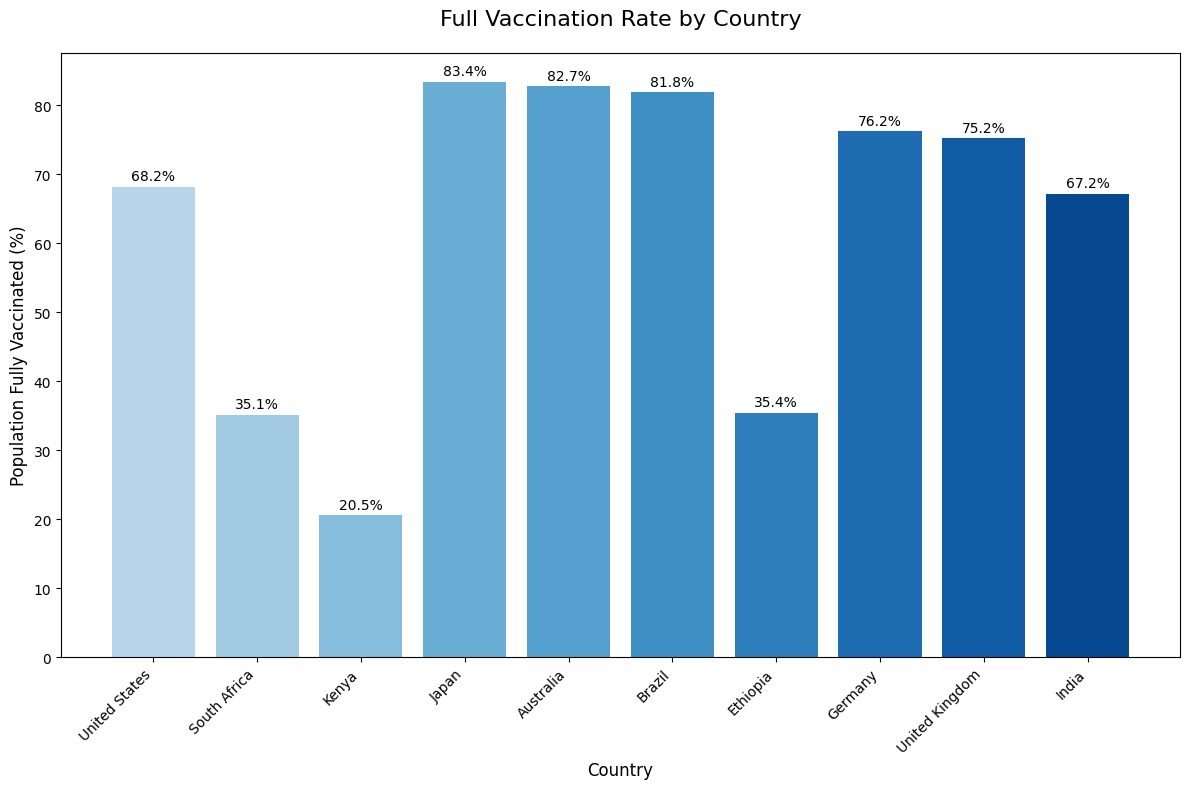

Full Vaccination Rates (%):
United States: 68.2%
South Africa: 35.1%
Kenya: 20.5%
Japan: 83.4%
Australia: 82.7%
Brazil: 81.8%
Ethiopia: 35.4%
Germany: 76.2%
United Kingdom: 75.2%
India: 67.2%


In [10]:
# Vaccination progress
if not df.empty:
    # Check if vaccination data is available
    if df_countries['people_fully_vaccinated'].sum() > 0:
        # Calculate vaccination rates
        df_countries['vaccination_rate'] = (df_countries['people_fully_vaccinated'] / df_countries['population']) * 100
        
        # Latest vaccination rate per country
        latest = df_countries.sort_values('date').groupby('location').tail(1)
        
        plt.figure(figsize=(12, 8))
        bars = plt.bar(latest['location'], latest['vaccination_rate'], color=plt.cm.Blues(np.linspace(0.3, 0.9, len(latest))))
        plt.title('Full Vaccination Rate by Country', fontsize=16, pad=20)
        plt.ylabel('Population Fully Vaccinated (%)', fontsize=12)
        plt.xlabel('Country', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Print the actual values
        print("Full Vaccination Rates (%):")
        for _, row in latest.iterrows():
            print(f"{row['location']}: {row['vaccination_rate']:.1f}%")
    else:
        print("Vaccination data not available in this dataset.")

## Per Capita Analysis
- Compare countries on a per capita basis for fair comparison

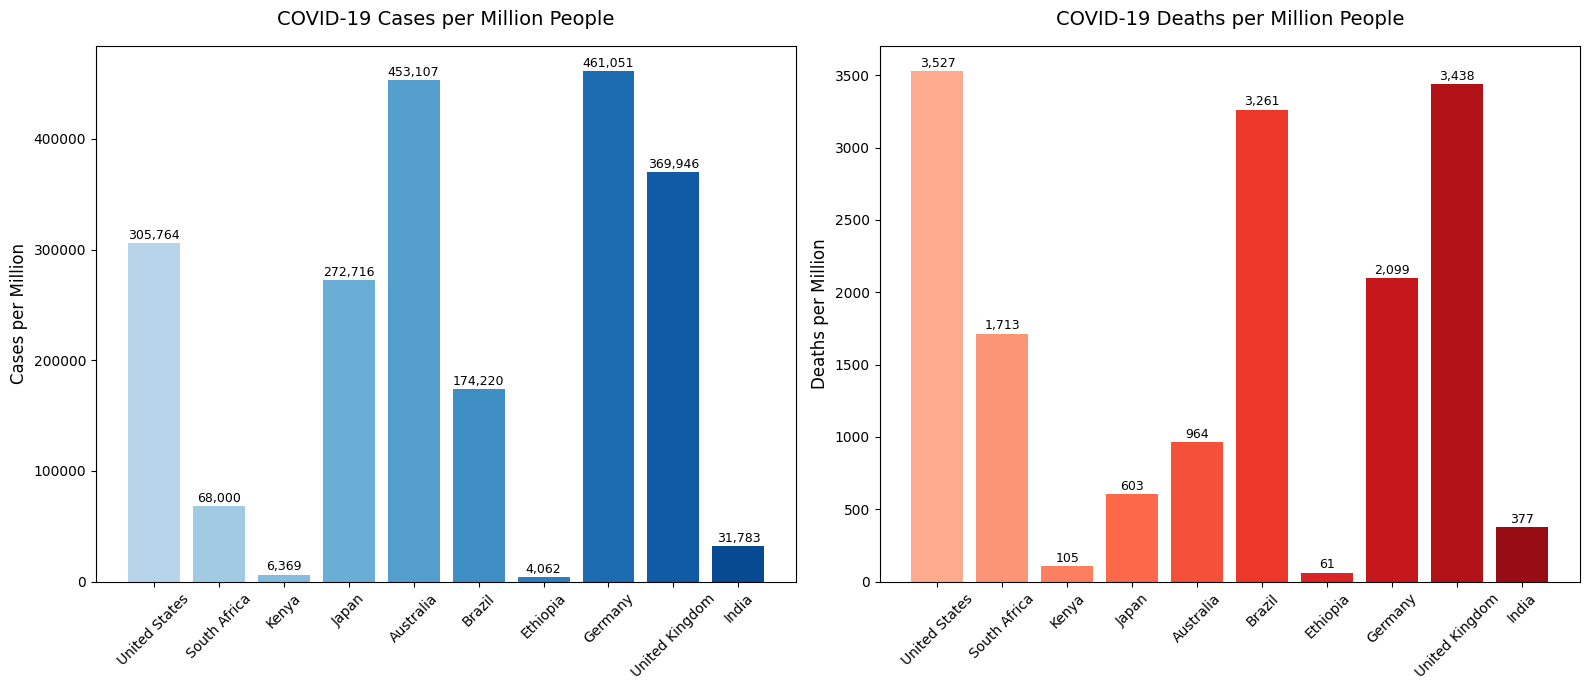

In [11]:
# Compare countries on a per capita basis
if not df.empty:
    # Get latest data for each country
    latest = df_countries.sort_values('date').groupby('location').tail(1)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Cases per million
    bars1 = ax1.bar(latest['location'], latest['cases_per_million'], 
                   color=plt.cm.Blues(np.linspace(0.3, 0.9, len(latest))))
    ax1.set_title('COVID-19 Cases per Million People', fontsize=14, pad=15)
    ax1.set_ylabel('Cases per Million', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # Deaths per million
    bars2 = ax2.bar(latest['location'], latest['deaths_per_million'], 
                   color=plt.cm.Reds(np.linspace(0.3, 0.9, len(latest))))
    ax2.set_title('COVID-19 Deaths per Million People', fontsize=14, pad=15)
    ax2.set_ylabel('Deaths per Million', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## Time-Aligned Trajectories
- Compare pandemic progression from similar starting points

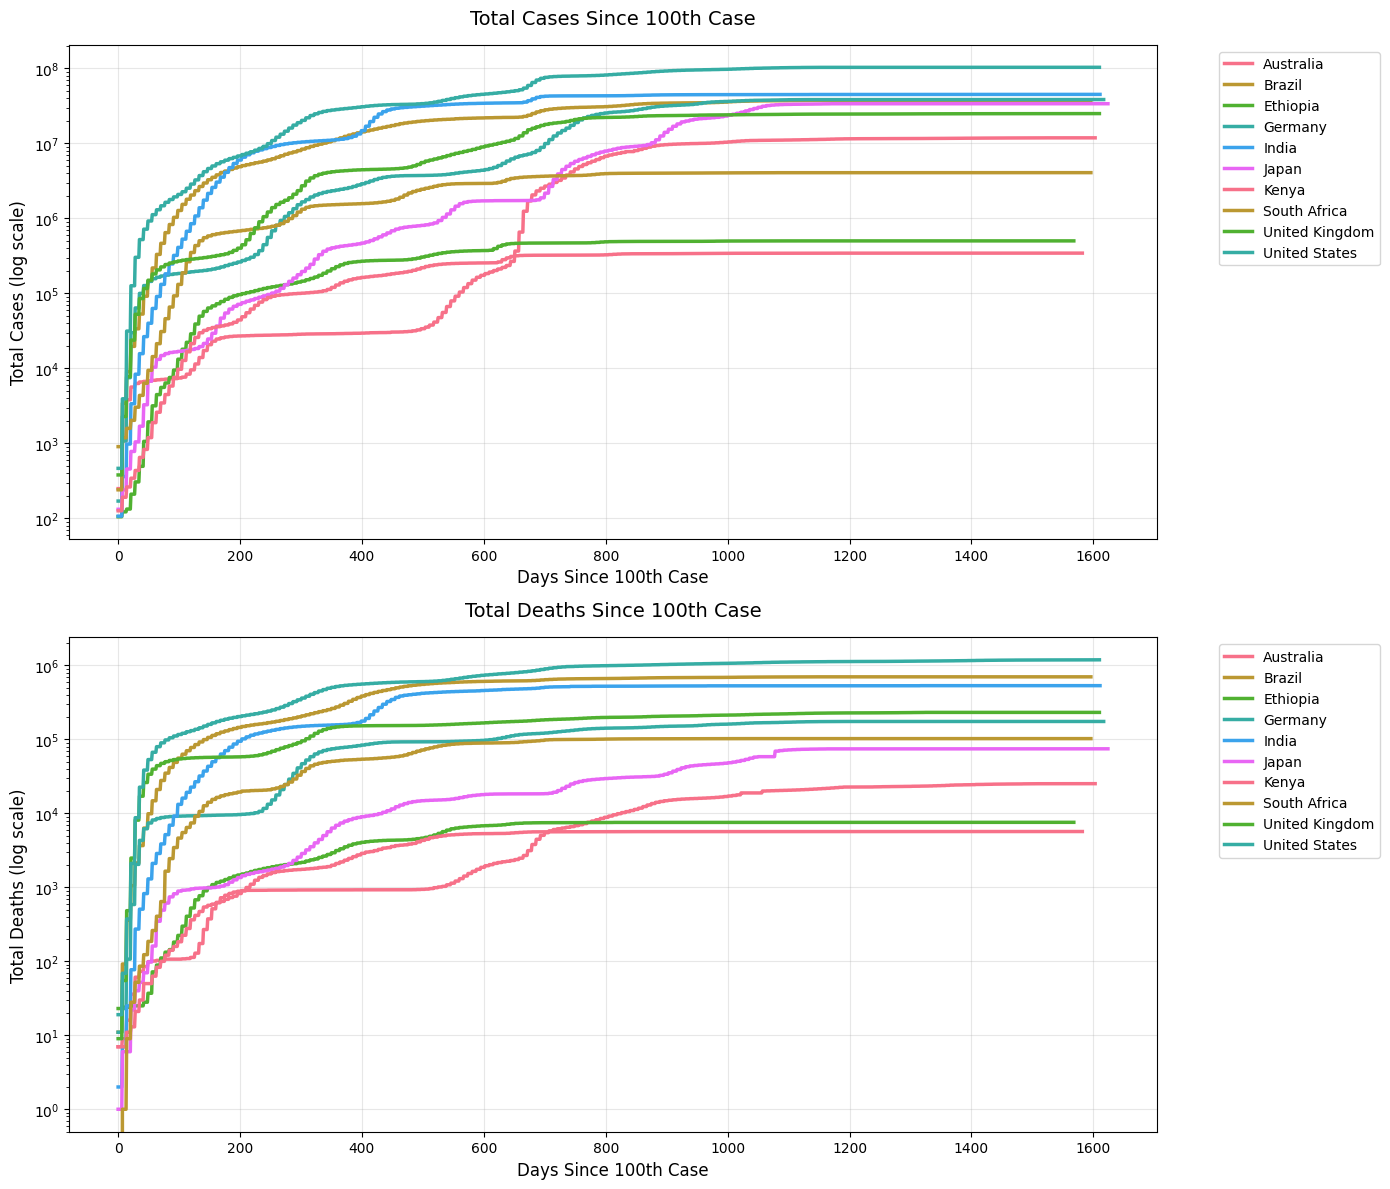

In [12]:
# Compare growth trajectories by aligning countries by first significant case count
if not df.empty:
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Find date when each country reached 100 cases
    country_start_dates = {}
    for country in df_countries['location'].unique():
        country_data = df_countries[df_countries['location'] == country]
        start_date = country_data[country_data['total_cases'] >= 100]['date'].min()
        if not pd.isna(start_date):
            country_start_dates[country] = start_date
    
    # Plot cases aligned by start date
    for country, start_date in country_start_dates.items():
        country_data = df_countries[df_countries['location'] == country]
        country_data = country_data[country_data['date'] >= start_date].copy()
        country_data['days_since_100_cases'] = (country_data['date'] - start_date).dt.days
        
        # Plot total cases
        axes[0].plot(country_data['days_since_100_cases'], 
                    country_data['total_cases'], 
                    label=country, linewidth=2.5)
        
        # Plot total deaths
        axes[1].plot(country_data['days_since_100_cases'], 
                    country_data['total_deaths'], 
                    label=country, linewidth=2.5)
    
    axes[0].set_title('Total Cases Since 100th Case', fontsize=14, pad=15)
    axes[0].set_xlabel('Days Since 100th Case', fontsize=12)
    axes[0].set_ylabel('Total Cases (log scale)', fontsize=12)
    axes[0].set_yscale('log')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Total Deaths Since 100th Case', fontsize=14, pad=15)
    axes[1].set_xlabel('Days Since 100th Case', fontsize=12)
    axes[1].set_ylabel('Total Deaths (log scale)', fontsize=12)
    axes[1].set_yscale('log')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Interactive Choropleth Map
Visualize total cases globally for the latest date (requires Plotly).

In [13]:
# Only if plotly is available
if not df.empty and plotly_available:
    # Prepare data for choropleth map
    # Get the latest date for each country
    latest_global = df.sort_values('date').groupby('iso_code').tail(1)
    
    # Create the choropleth map
    fig = px.choropleth(latest_global, 
                        locations='iso_code', 
                        color='total_cases_per_million',
                        hover_name='location', 
                        hover_data=['total_cases', 'total_deaths', 'population'],
                        color_continuous_scale='Reds',
                        title='Global COVID-19 Cases per Million People - Latest',
                        labels={'total_cases_per_million': 'Cases per Million'})
    fig.show()
elif not df.empty and not plotly_available:
    print("Plotly is not available. Install it with: pip install plotly")

## Insights & Findings
- Compare trends between countries
- Identify spikes, peaks, or anomalies
- Analyze vaccination rollout effectiveness

In [14]:
# Generate insights report
if not df.empty:
    print("="*50)
    print("COVID-19 ANALYSIS REPORT")
    print("="*50)
    
    # Get latest data for each country
    latest = df_countries.sort_values('date').groupby('location').tail(1)
    
    # Summary statistics
    total_cases = latest['total_cases'].sum()
    total_deaths = latest['total_deaths'].sum()
    avg_death_rate = latest['death_rate'].mean() * 100
    
    print(f"\nGlobal Summary (Selected Countries):")
    print(f"Total Cases: {total_cases:,.0f}")
    print(f"Total Deaths: {total_deaths:,.0f}")
    print(f"Average Death Rate: {avg_death_rate:.2f}%")
    
    # Country with highest cases
    highest_cases = latest.loc[latest['total_cases'].idxmax()]
    print(f"\nCountry with Highest Cases: {highest_cases['location']} ({highest_cases['total_cases']:,.0f} cases)")
    
    # Country with highest death rate
    highest_dr = latest.loc[latest['death_rate'].idxmax()]
    print(f"Country with Highest Death Rate: {highest_dr['location']} ({highest_dr['death_rate']*100:.2f}%)")
    
    # Country with highest cases per capita
    highest_cases_pc = latest.loc[latest['cases_per_million'].idxmax()]
    print(f"Country with Highest Cases per Million: {highest_cases_pc['location']} ({highest_cases_pc['cases_per_million']:,.0f})")
    
    # Country with highest deaths per capita
    highest_deaths_pc = latest.loc[latest['deaths_per_million'].idxmax()]
    print(f"Country with Highest Deaths per Million: {highest_deaths_pc['location']} ({highest_deaths_pc['deaths_per_million']:,.0f})")
    
    # Vaccination progress if available
    if 'vaccination_rate' in latest.columns:
        highest_vax = latest.loc[latest['vaccination_rate'].idxmax()]
        print(f"Country with Highest Vaccination Rate: {highest_vax['location']} ({highest_vax['vaccination_rate']:.1f}%)")
    
    # Save processed data
    df_countries.to_csv('processed_covid_data.csv', index=False)
    print(f"\nProcessed data saved to 'processed_covid_data.csv'")
    
    print("\nAnalysis complete!")

COVID-19 ANALYSIS REPORT

Global Summary (Selected Countries):
Total Cases: 299,985,680
Total Deaths: 3,051,783
Average Death Rate: 1.17%

Country with Highest Cases: United States (103,436,829 cases)
Country with Highest Death Rate: South Africa (2.52%)
Country with Highest Cases per Million: Germany (461,051)
Country with Highest Deaths per Million: United States (3,527)
Country with Highest Vaccination Rate: Japan (83.4%)

Processed data saved to 'processed_covid_data.csv'

Analysis complete!
